<a href="https://colab.research.google.com/github/2653319/book-example/blob/main/%E4%BD%BF%E7%94%A8%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%95%B8%E6%93%9A%E8%A8%93%E7%B7%B4%E5%96%AE%E5%B1%A4%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 未分級實驗室：使用時間序列數據訓練單層神經網絡

既然您已經在前一周看到了統計方法，那麼您現在將轉向使用神經網絡來構建您的預測模型。您將從本筆記本中的一個簡單網絡開始，並在接下來的幾週內轉向更複雜的架構。在本實驗結束時，您將能夠：

* 構建一個單層網絡並使用您在上一個實驗室中使用的相同合成數據對其進行訓練
* 為訓練和評估準備時間序列數據
* 根據驗證集衡量模型的性能

## Imports


您將首先導入執行本實驗中所有代碼所需的包。您將使用：
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) 構建模型並準備數據窗口
* [Numpy](https://numpy.org/) 用於數值處理
* 和 Matplotlib 的 [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) 庫進行可視化

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 實用程序

然後，您將定義一些您在之前的實驗中也看到的實用程序函數。這些將負責可視化您的時間序列數據和模型預測，以及生成合成數據。

In [ ]:
def plot_series(time, series, format="-", start=0, end=None): #繪圖 時間步和數值
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0): #斜直線
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):  #季節性
    """
    只是一個任意的模式，如果你願意，你可以改變它
    
    Args:
      season_time (array of float) - 包含每個時間步的測量值

    Returns:
      data_pattern (array of float) - 包含根據修訂的測量值
                                  到定義的模式
    """

    # 使用任意模式生成值
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0): #季節性
    """
    
    在每個週期重複相同的模式

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # 定義每個週期的測量值
    season_time = ((time + phase) % period) / period

    # 生成按定義幅度縮放的季節性數據

    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None): #雜音
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise


## 生成合成數據

下面的代碼生成您在上一個實驗室中使用的相同合成數據。它將包含 1,461 個具有趨勢、季節性和噪聲的數據點。

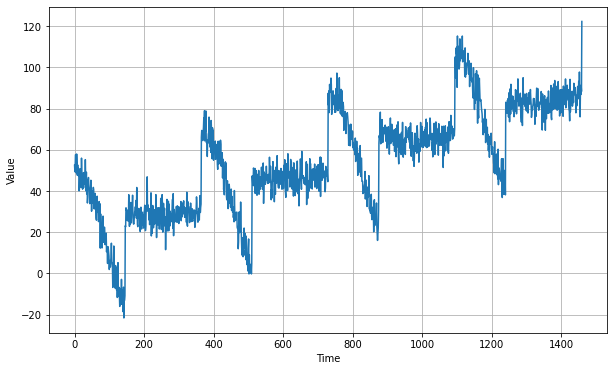

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)


## 拆分數據集

接下來，您將把上面的數據分成訓練集和驗證集。您將獲得前 1,000 分用於訓練，其餘用於驗證，

In [ ]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

您可以使用相同的繪圖實用程序函數直觀地檢查這些集合。請注意，通常，驗證集的值（即 y 軸）高於訓練集中的值。您的模型應該能夠僅通過從訓練集的趨勢和季節性中學習來預測這些值。

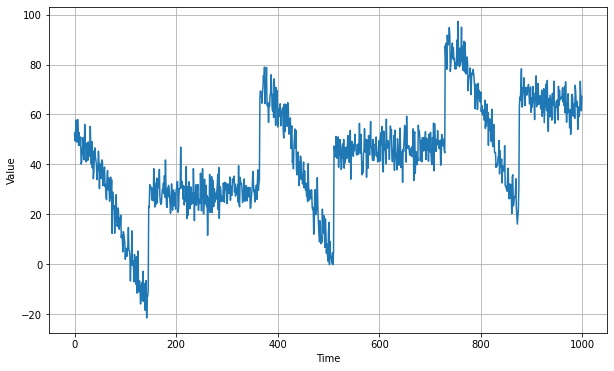

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

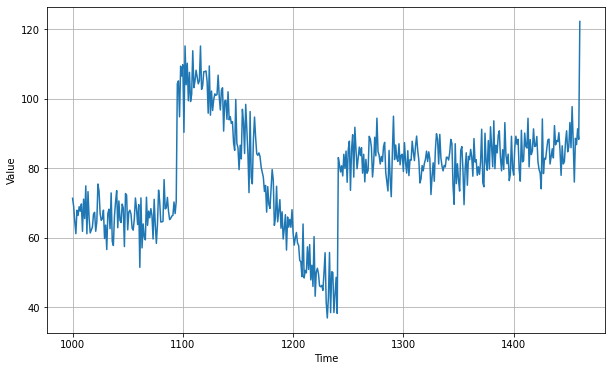

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

## 準備特徵和標籤

然後，您將準備數據窗口，如上一個實驗所示。最好在單獨的單元格中聲明參數，以便以後可以根據需要輕鬆調整它。

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

以下函數包含您在上一個實驗中執行的所有預處理步驟。這使其模塊化，因此您可以在需要時輕鬆在其他項目中使用它。

這裡要注意的一件事是調用 `dataset.window()` 時的 `window_size + 1`。有一個 `+1` 表示您將下一個點作為標籤。例如，前 20 個點將是要素，因此第 21 個點將是標籤。

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """生成數據集window

    Args:
      series (array of float) - 包含時間序列的值
      window_size (int) - 包含在特徵中的時間步數
      batch_size (int) - 批量大小
      shuffle_buffer(int) - 用於 shuffle 方法的緩衝區大小

    Returns:
      dataset (TF Dataset) - 包含時間窗的 TF 數據集
    """
  
    # 從系列值生成 TF 數據集
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # 窗口化數據，但只取指定大小的數據
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # 通過將其元素放在一個批次中來展平窗戶
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # 創建具有特徵和標籤的元組
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # 創建批量窗口
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


現在您可以從訓練集中生成數據集窗口。

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

您可以再次檢查輸出以查看函數是否按預期運行。下面的代碼將使用 `tf.data.Dataset` API 的 [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) 方法來抓取一個單批。然後它將打印該批次的幾個屬性，例如元素的數據類型和形狀。正如預期的那樣，它應該有一個 2 元素元組（即 `(feature, label)`），並且它們的形狀應該與您之前聲明的批處理和窗口大小對齊，默認情況下分別為 `32` 和 `20` .

In [ ]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') #x
  print(f'shape of second element: {windows[1].shape}') #y
  print(windows) #包含x和y  根據前20個 預測地21個

## 構建並編譯模型

接下來，您將構建單層神經網絡。這將只是一個單元 [Dense](https://keras.io/api/layers/core_layers/dense/) 層，如下所示。您將圖層分配給變量“l0”，以便稍後使用 [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 查看最終權重/Layer#get_weights) 方法。

In [ ]:
# 構建單層神經網絡
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.05944392],
       [ 0.25831848],
       [ 0.4362073 ],
       [ 0.14751035],
       [ 0.20763445],
       [ 0.04863662],
       [-0.00550276],
       [-0.10379919],
       [-0.3192303 ],
       [-0.15213224],
       [ 0.17363471],
       [-0.20059031],
       [-0.41913453],
       [ 0.39287764],
       [-0.33475503],
       [ 0.35794824],
       [-0.2163395 ],
       [-0.3227521 ],
       [-0.18780732],
       [ 0.44607776]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


您將設置 [*均方誤差 (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) 作為損失函數並使用 [*隨機梯度下降 (SGD) *](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) 在訓練期間優化權重。

In [ ]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))


## 訓練模型

現在您可以繼續訓練您的模型。您將輸入準備好的數據窗口並運行 100 個 epoch 的訓練。

In [ ]:
# Train the model
model.fit(dataset,epochs=100)

您可以通過再次調用 `get_weights()` 方法查看最終權重。

In [ ]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.07515696],
       [ 0.00895261],
       [ 0.07244402],
       [-0.02207888],
       [ 0.01847991],
       [ 0.01619421],
       [-0.00976456],
       [ 0.01564306],
       [-0.06661951],
       [ 0.02911463],
       [ 0.04035323],
       [-0.00268754],
       [-0.1133795 ],
       [ 0.12458928],
       [-0.04222873],
       [ 0.14455223],
       [-0.00389935],
       [ 0.11957018],
       [ 0.22834456],
       [ 0.51564926]], dtype=float32), array([0.01325024], dtype=float32)]


## 模型預測

訓練完成後，您現在可以測量模型的性能。您可以通過傳遞一批數據窗口來生成模型預測。如果您要從原始的 `series` 數組中切出一個窗口，則需要在將其傳遞給模型之前添加一個批處理維度。這可以通過使用 [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) 常量或使用 [`np. expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) 方法。

In [ ]:
series[0:20]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
       57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
       50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
       44.454983, 41.76799 ], dtype=float32)

In [ ]:
series[0:20][np.newaxis]

array([[52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
        57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
        50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
        44.454983, 41.76799 ]], dtype=float32)

dataset輸入的資料大小是(32,20)
，32批，每批20個
原本直接從series拿資料的話是(20) ，但輸入格式必須是(批數,單批數量)，而預測只需1批20個單字，就能預測出第21個。 
因此改成(1,20)，
輸入1批，20個數字



In [ ]:
# 前 20 個數據點切片的形狀
print(f'shape of series[0:20]: {series[0:20].shape}')

# 添加批次尺寸後的形狀
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# 添加批次尺寸後的形狀（替代方式）
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# 樣本模型預測
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
model prediction: [[43.030422]]


要計算指標，您需要為驗證集生成模型預測。請記住，該集合指的是整個系列的索引“1000”到“1460”處的點。您將需要編寫步驟以從您的模型中生成這些步驟。下面的單元格演示了一種方法。

基本上，它一次將整個系列提供給您的模型 20 個點，並將所有結果附加到“預測”列表中。然後它將切片對應於驗證集的點。

下面的切片索引是`split_time - window_size:`，因為預測列表比系列小20個點（即窗口大小）。由於窗口大小為 20，“預測”列表中的第一個數據點對應於索引“20”處的時間預測。您無法在索引“0”到“19”處進行預測，因為它們小於窗口大小。因此，當您使用 `split_time - window_size:` 進行切片時，您將獲得與驗證集中的時間索引對齊的點。split_time = 1000 要預測1000 ~ 1461，因為window_size = 20，所以需要擷取980~1000才能預測第1001個

*注意：您可能會注意到此單元需要一段時間才能運行。在接下來的兩個實驗中，您將看到生成預測以使代碼運行得更快的其他方法。您可能已經有了一些想法，並在完成本實驗後隨時嘗試。*

In [ ]:
# Initialize a list
forecast = []

# 使用模型預測每個窗口大小的數據點
for time in range(len(series) - window_size): #1461 - 20
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
                  #series[0:20][1]
# 切片與驗證集對齊的點
forecast = forecast[split_time - window_size:]
          #forecast[970:]
# 比較預測和驗證集中的元素數量
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 461
shape of the validation set: (461,)



為了可視化結果，您需要將預測轉換為 `plot_series()` 實用程序函數接受的形式。這涉及將列表轉換為 numpy 數組並刪除一維軸。

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


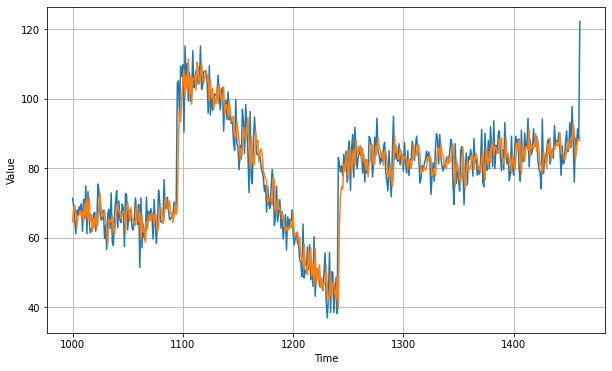

In [ ]:
# 使用轉換和擠壓方法後預覽形狀
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
   #.squeeze() 刪除維度 預設值為None  則刪除全部維度

# 轉換為 numpy 數組並刪除一維軸
results = np.array(forecast).squeeze()  #大概是 [[[461,]]] -> [461]

# 用驗證集覆蓋結果
plot_series(time_valid, (x_valid, results))


您可以通過調用與以前相同的函數來計算指標。您將獲得接近 5 的 MAE。

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.114223
5.140455


## Wrap Up

在本實驗室中，您能夠構建和訓練時間序列數據的單層神經網絡。您準備了數據窗口，將它們輸入模型，最終預測顯示的結果與您在第 1 週所做的統計分析相當。在接下來的實驗中，您將嘗試添加更多層，並查看您可以在何時進行的一些優化訓練你的模型。